In [2]:
import pandas as pd
import geopandas
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import contextily as cx
from datetime import datetime

In [4]:
brighton_demand = pd.read_csv("brighton_demand.csv").drop(columns=["Unnamed: 0"])
brighton_sites = geopandas.read_file("brighton_sites.geojson")
brighton_travel = pd.read_csv("brighton_travel_matrix_driving.csv").drop(columns=["Unnamed: 0"])

In [6]:
def generate_solution_metrics(self, site_list):
    problem = self.evaluate_solution(site_list)

    # Return weighted average
    weighted_average = np.average(problem['min_cost'], weights=problem[self.demand_col])
    unweighted_average = np.average(problem['min_cost'])
    max_travel = np.max(problem['min_cost'])

    return {
        'site_indices': site_list,
        'site_names': ", ".join(self.travel_matrix.columns[site_list].tolist()),
        'weighted_average': weighted_average,
        'unweighted_average': unweighted_average,
        'max': max_travel,
        'problem_df': problem
    }

In [7]:
# Tweaked WeightedAverageObjective from Metapy package
# https://github.com/health-data-science-OR/healthcare-logistics/tree/master/optimisation/metapy
# Credit: Tom Monks

class FacilityLocationObjective:
    '''
    Encapsulates logic for calculation of
    metrics in a simple facility location problem

    Demand and travel matrices must have a common column

    demand: pd.dataframe:  Two column dataframe. One column should be labels for the
    demand locations (e.g. LSOA identifiers, postcodes). Second column should contain
    demand figures of some kind (e.g. number of historical cases)
    If demand assumed to be equal, all values in this column could be 1.

    travel_matrix: pd.dataframe: dataframe with columns representing sites
    and rows representing locations demand will come from.
    One column should be labels for the demand locations (e.g. LSOA identifiers, postcodes).
    All other values will be either distance or time in float form.
    No additional columns of information must be included or they will be used as part of the
    calculation of the lowest-cost solution, which may lead to incorrect results.
    '''
    def __init__(self, demand, travel_matrix, merge_col, demand_col):
        '''
        Store the demand and travel times

        Args:
            demand: pd.DataFrame:

            travel_matrix: pd.DataFrame:
        '''
        self.demand = demand.set_index(merge_col)
        self.travel_matrix = travel_matrix.set_index(merge_col)
        self.demand_col = demand_col


    def evaluate_solution(self, site_list):
        '''
        Calculates the

        Args:
            site_list: list: column indices of solution to evaluate
                            (to apply to travel matrix)

            merge_col: str: name of shared column in demand df and travel time
                    df that contains labels for areas that can be merged on (e.g. "lsoa")

            n_patients_or_referrals_col: str: name of column containing numeric data
                                            (e.g. "n_patients", "referrals")

        Returns:
            Pandas dataframe to pass to evaluation functions

        '''

        active_facilities = self.travel_matrix.iloc[:, site_list].copy()

        # Assume travel to closest facility
        # Need to drop the column that contains
        active_facilities['min_cost'] = active_facilities.min(axis=1)


        # Merge demand and travel times into a single DataFrame
        problem = self.demand.merge(active_facilities,
                                    left_index=True, right_index=True,
                                    how='inner')

        return problem.reset_index()


    def generate_solution_metrics(self, site_list):
        '''
        Calculates the weighted average travel time for selected sites

        Args:
            site_list: list or np.array: A list of site IDs as a list or array (e.g. [0, 3, 4])
            merge_col: string: The column name to use for merging the data.
            n_patients_or_referrals_col: string: The column name to use for the number of patients or referrals.

        Returns:
            A tuple containing the problem and the maximum travel time.
        '''
        problem = self.evaluate_solution(site_list)

        # Return weighted average
        weighted_average = np.average(problem['min_cost'], weights=problem[self.demand_col])
        unweighted_average = np.average(problem['min_cost'])
        max_travel = np.max(problem['min_cost'])

        return {
            'site_indices': site_list,
            'site_names': ", ".join(self.travel_matrix.columns[site_list].tolist()),
            'weighted_average': weighted_average,
            'unweighted_average': unweighted_average,
            'max': max_travel,
            'problem_df': problem
        }

In [8]:
location_problem_brighton = FacilityLocationObjective(
    demand=brighton_demand,
    travel_matrix=brighton_travel,
    merge_col="LSOA",
    demand_col="demand"
    )

In [9]:
location_problem_brighton

In [10]:
location_problem_brighton.demand

,demand
LSOA,
Brighton and Hove 027E,3627
Brighton and Hove 027F,2323
Brighton and Hove 027A,2596
Brighton and Hove 029E,3132
Brighton and Hove 029D,2883
...,...
Brighton and Hove 012A,2497
Brighton and Hove 005C,2570
Brighton and Hove 012B,2051


In [11]:
location_problem_brighton.travel_matrix

,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6
LSOA,,,,,,
Brighton and Hove 027E,773.93,527.69,444.29,491.85,607.54,554.91
Brighton and Hove 027F,757.39,499.11,517.57,561.07,578.97,538.37
Brighton and Hove 027A,763.24,601.38,517.98,410.40,681.23,557.35
Brighton and Hove 029E,743.62,651.72,660.36,379.72,731.58,557.58
Brighton and Hove 029D,665.85,664.65,658.20,313.00,744.50,570.51
...,...,...,...,...,...,...
Brighton and Hove 012A,446.54,884.70,1108.11,519.16,626.02,447.78
Brighton and Hove 005C,469.80,784.83,1008.24,569.40,526.15,347.91
Brighton and Hove 012B,464.53,909.18,1132.60,537.15,650.51,472.26


In [12]:
location_problem_brighton.evaluate_solution(
    [0,1,2]
    )

,LSOA,demand,Site 1,Site 2,Site 3,min_cost
0,Brighton and Hove 027E,3627,773.93,527.69,444.29,444.29
1,Brighton and Hove 027F,2323,757.39,499.11,517.57,499.11
2,Brighton and Hove 027A,2596,763.24,601.38,517.98,517.98
3,Brighton and Hove 029E,3132,743.62,651.72,660.36,651.72
4,Brighton and Hove 029D,2883,665.85,664.65,658.20,658.20
...,...,...,...,...,...,...
160,Brighton and Hove 012A,2497,446.54,884.70,1108.11,446.54
161,Brighton and Hove 005C,2570,469.80,784.83,1008.24,469.80
162,Brighton and Hove 012B,2051,464.53,909.18,1132.60,464.53
163,Brighton and Hove 005A,1164,567.49,882.52,1105.93,567.49


In [13]:
location_problem_brighton.evaluate_solution(
    [2,3,5]
    )

,LSOA,demand,Site 3,Site 4,Site 6,min_cost
0,Brighton and Hove 027E,3627,444.29,491.85,554.91,444.29
1,Brighton and Hove 027F,2323,517.57,561.07,538.37,517.57
2,Brighton and Hove 027A,2596,517.98,410.40,557.35,410.40
3,Brighton and Hove 029E,3132,660.36,379.72,557.58,379.72
4,Brighton and Hove 029D,2883,658.20,313.00,570.51,313.00
...,...,...,...,...,...,...
160,Brighton and Hove 012A,2497,1108.11,519.16,447.78,447.78
161,Brighton and Hove 005C,2570,1008.24,569.40,347.91,347.91
162,Brighton and Hove 012B,2051,1132.60,537.15,472.26,472.26
163,Brighton and Hove 005A,1164,1105.93,664.11,445.60,445.60


In [14]:
location_problem_brighton.evaluate_solution(
    [0,1]
    )

,LSOA,demand,Site 1,Site 2,min_cost
0,Brighton and Hove 027E,3627,773.93,527.69,527.69
1,Brighton and Hove 027F,2323,757.39,499.11,499.11
2,Brighton and Hove 027A,2596,763.24,601.38,601.38
3,Brighton and Hove 029E,3132,743.62,651.72,651.72
4,Brighton and Hove 029D,2883,665.85,664.65,664.65
...,...,...,...,...,...
160,Brighton and Hove 012A,2497,446.54,884.70,446.54
161,Brighton and Hove 005C,2570,469.80,784.83,469.80
162,Brighton and Hove 012B,2051,464.53,909.18,464.53
163,Brighton and Hove 005A,1164,567.49,882.52,567.49


In [15]:
location_problem_brighton.evaluate_solution(
    [0,1]
    )

,LSOA,demand,Site 1,Site 2,min_cost
0,Brighton and Hove 027E,3627,773.93,527.69,527.69
1,Brighton and Hove 027F,2323,757.39,499.11,499.11
2,Brighton and Hove 027A,2596,763.24,601.38,601.38
3,Brighton and Hove 029E,3132,743.62,651.72,651.72
4,Brighton and Hove 029D,2883,665.85,664.65,664.65
...,...,...,...,...,...
160,Brighton and Hove 012A,2497,446.54,884.70,446.54
161,Brighton and Hove 005C,2570,469.80,784.83,469.80
162,Brighton and Hove 012B,2051,464.53,909.18,464.53
163,Brighton and Hove 005A,1164,567.49,882.52,567.49


In [16]:
location_problem_brighton.generate_solution_metrics(
    [0,1,2]
    )

{'site_indices': [0, 1, 2],
 'site_names': 'Site 1, Site 2, Site 3',
 'weighted_average': 388.2282566237676,
 'unweighted_average': 383.234,
 'max': 1001.33,
 'problem_df':                        LSOA  demand  Site 1  Site 2   Site 3  min_cost
 0    Brighton and Hove 027E    3627  773.93  527.69   444.29    444.29
 1    Brighton and Hove 027F    2323  757.39  499.11   517.57    499.11
 2    Brighton and Hove 027A    2596  763.24  601.38   517.98    517.98
 3    Brighton and Hove 029E    3132  743.62  651.72   660.36    651.72
 4    Brighton and Hove 029D    2883  665.85  664.65   658.20    658.20
 ..                      ...     ...     ...     ...      ...       ...
 160  Brighton and Hove 012A    2497  446.54  884.70  1108.11    446.54
 161  Brighton and Hove 005C    2570  469.80  784.83  1008.24    469.80
 162  Brighton and Hove 012B    2051  464.53  909.18  1132.60    464.53
 163  Brighton and Hove 005A    1164  567.49  882.52  1105.93    567.49
 164  Brighton and Hove 005B    1097

In [17]:
solution = location_problem_brighton.generate_solution_metrics(
    [0,1,2]
    )

solution['weighted_average']

388.2282566237676

In [18]:
location_problem_brighton.generate_solution_metrics(
    [0,1,3]
    )['weighted_average'].round(2)

427.93

In [19]:
def all_combinations(n_facilities, p):
    facility = np.arange(n_facilities, dtype=np.uint8)
    return [np.array(a) for a in combinations(facility, p)]

In [20]:
possible_combinations_brighton = all_combinations(
    len(location_problem_brighton.travel_matrix.columns),
    4
    )

possible_combinations_brighton

[array([0, 1, 2, 3], dtype=uint8),
 array([0, 1, 2, 4], dtype=uint8),
 array([0, 1, 2, 5], dtype=uint8),
 array([0, 1, 3, 4], dtype=uint8),
 array([0, 1, 3, 5], dtype=uint8),
 array([0, 1, 4, 5], dtype=uint8),
 array([0, 2, 3, 4], dtype=uint8),
 array([0, 2, 3, 5], dtype=uint8),
 array([0, 2, 4, 5], dtype=uint8),
 array([0, 3, 4, 5], dtype=uint8),
 array([1, 2, 3, 4], dtype=uint8),
 array([1, 2, 3, 5], dtype=uint8),
 array([1, 2, 4, 5], dtype=uint8),
 array([1, 3, 4, 5], dtype=uint8),
 array([2, 3, 4, 5], dtype=uint8)]

In [21]:
outputs = []

for possible_solution in possible_combinations_brighton:
    outputs.append(
        location_problem_brighton.generate_solution_metrics(
        possible_solution
    )
)

In [22]:
outputs

[{'site_indices': array([0, 1, 2, 3], dtype=uint8),
  'site_names': 'Site 1, Site 2, Site 3, Site 4',
  'weighted_average': 313.25708575468923,
  'unweighted_average': 312.56575757575763,
  'max': 1001.33,
  'problem_df':                        LSOA  demand  Site 1  Site 2   Site 3  Site 4  min_cost
  0    Brighton and Hove 027E    3627  773.93  527.69   444.29  491.85    444.29
  1    Brighton and Hove 027F    2323  757.39  499.11   517.57  561.07    499.11
  2    Brighton and Hove 027A    2596  763.24  601.38   517.98  410.40    410.40
  3    Brighton and Hove 029E    3132  743.62  651.72   660.36  379.72    379.72
  4    Brighton and Hove 029D    2883  665.85  664.65   658.20  313.00    313.00
  ..                      ...     ...     ...     ...      ...     ...       ...
  160  Brighton and Hove 012A    2497  446.54  884.70  1108.11  519.16    446.54
  161  Brighton and Hove 005C    2570  469.80  784.83  1008.24  569.40    469.80
  162  Brighton and Hove 012B    2051  464.53  909.

In [23]:
pd.DataFrame(outputs)

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df
0,"[0, 1, 2, 3]","Site 1, Site 2, Site 3, Site 4",313.257086,312.565758,1001.33,LSOA demand Site 1 S...
1,"[0, 1, 2, 4]","Site 1, Site 2, Site 3, Site 5",374.295378,370.452061,1001.33,LSOA demand Site 1 S...
2,"[0, 1, 2, 5]","Site 1, Site 2, Site 3, Site 6",368.551505,355.460000,1001.33,LSOA demand Site 1 S...
3,"[0, 1, 3, 4]","Site 1, Site 2, Site 4, Site 5",397.907659,385.938061,1302.58,LSOA demand Site 1 S...
4,"[0, 1, 3, 5]","Site 1, Site 2, Site 4, Site 6",410.033802,388.522909,1371.46,LSOA demand Site 1 S...
5,"[0, 1, 4, 5]","Site 1, Site 2, Site 5, Site 6",460.215392,436.115273,1302.58,LSOA demand Site 1 S...
6,"[0, 2, 3, 4]","Site 1, Site 3, Site 4, Site 5",304.810704,306.939576,1001.33,LSOA demand Site 1 ...
7,"[0, 2, 3, 5]","Site 1, Site 3, Site 4, Site 6",313.630625,311.418303,1001.33,LSOA demand Site 1 ...
8,"[0, 2, 4, 5]","Site 1, Site 3, Site 5, Site 6",363.242023,354.221818,1001.33,LSOA demand Site 1 ...
9,"[0, 3, 4, 5]","Site 1, Site 4, Site 5, Site 6",414.657901,393.878606,1302.58,LSOA demand Site 1 S...


In [24]:
pd.DataFrame(outputs).sort_values('weighted_average').round(1)

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df
6,"[0, 2, 3, 4]","Site 1, Site 3, Site 4, Site 5",304.8,306.9,1001.3,LSOA demand Site 1 ...
14,"[2, 3, 4, 5]","Site 3, Site 4, Site 5, Site 6",306.4,302.9,1001.3,LSOA demand Site 3 ...
11,"[1, 2, 3, 5]","Site 2, Site 3, Site 4, Site 6",311.8,304.2,1001.3,LSOA demand Site 2 ...
0,"[0, 1, 2, 3]","Site 1, Site 2, Site 3, Site 4",313.3,312.6,1001.3,LSOA demand Site 1 S...
7,"[0, 2, 3, 5]","Site 1, Site 3, Site 4, Site 6",313.6,311.4,1001.3,LSOA demand Site 1 ...
10,"[1, 2, 3, 4]","Site 2, Site 3, Site 4, Site 5",316.9,319.8,1001.3,LSOA demand Site 2 ...
8,"[0, 2, 4, 5]","Site 1, Site 3, Site 5, Site 6",363.2,354.2,1001.3,LSOA demand Site 1 ...
2,"[0, 1, 2, 5]","Site 1, Site 2, Site 3, Site 6",368.6,355.5,1001.3,LSOA demand Site 1 S...
1,"[0, 1, 2, 4]","Site 1, Site 2, Site 3, Site 5",374.3,370.5,1001.3,LSOA demand Site 1 S...
12,"[1, 2, 4, 5]","Site 2, Site 3, Site 5, Site 6",379.7,370.4,1001.3,LSOA demand Site 2 ...


In [25]:
pd.DataFrame(outputs).sort_values('weighted_average').head(1)['site_names'].values

array(['Site 1, Site 3, Site 4, Site 5'], dtype=object)

In [26]:
outputs_df = pd.DataFrame(outputs)
outputs_df['weighted_average_minutes'] = (outputs_df['weighted_average']/60).round(2)

px.bar(
    data_frame=outputs_df.sort_values("weighted_average_minutes", ascending=False),
    y="site_names",
    x="weighted_average_minutes",
    title="Possible Site Combinations"
)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'weighted_average_minutes=%{x}<br>site_names=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array([7.67, 6.91, 6.83, 6.66, 6.63, 6.33, 6.24, 6.14, 6.05, 5.28, 5.23, 5.22,
                          5.2 , 5.11, 5.08]),
              'xaxis': 'x',
              'y': array(['Site 1, Site 2, Site 5, Site 6', 'Site 1, Site 4, Site 5, Site 6',
                          'Site 1, Site 2, Site 4, Site 6', 'Site 2, Site 4, Site 5, Site 6',
                          'Site 1, Site 2, Site 4, Site 5', 'Site 2, Site 3, Site 5, Site 6',
                          'Site 1, Site 2, Site 3, Site 5', 'Site 1, Site 2, Site 3, Site 6',
                          'Site 1, Site 3, Site 5, Site 6', 'Site 2, Site 3, Site 4, Site 5',
                          'Site 1, Site 3, Site 4, Site 6', 'Site 1, Site 2, Site 3, Site 4',
                          'Site 2, Site 3, Site 4, Site 6', 'Site 3, Site 4, Site 5, Site 6',
                          'Site 1, Site 3, Site 4, Site 5'], dtype=object),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Possible Site Combinations'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'weighted_average_minutes'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'site_names'}}}
})

In [27]:
best_solution = pd.DataFrame(outputs).sort_values('weighted_average').head(1)
best_solution_df = best_solution['problem_df'].values[0]
best_solution_df

,LSOA,demand,Site 1,Site 3,Site 4,Site 5,min_cost
0,Brighton and Hove 027E,3627,773.93,444.29,491.85,607.54,444.29
1,Brighton and Hove 027F,2323,757.39,517.57,561.07,578.97,517.57
2,Brighton and Hove 027A,2596,763.24,517.98,410.40,681.23,410.40
3,Brighton and Hove 029E,3132,743.62,660.36,379.72,731.58,379.72
4,Brighton and Hove 029D,2883,665.85,658.20,313.00,744.50,313.00
...,...,...,...,...,...,...,...
160,Brighton and Hove 012A,2497,446.54,1108.11,519.16,626.02,446.54
161,Brighton and Hove 005C,2570,469.80,1008.24,569.40,526.15,469.80
162,Brighton and Hove 012B,2051,464.53,1132.60,537.15,650.51,464.53
163,Brighton and Hove 005A,1164,567.49,1105.93,664.11,623.84,567.49


In [28]:
best_solution

,site_indices,site_names,weighted_average,unweighted_average,max,problem_df
6,"[0, 2, 3, 4]","Site 1, Site 3, Site 4, Site 5",304.810704,306.939576,1001.33,LSOA demand Site 1 ...


In [29]:
lsoa_boundaries = geopandas.read_file("LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4.geojson")

In [30]:
brighton_sites

,site,geometry
0,Site 1,POINT (-0.19544 50.84511)
1,Site 2,POINT (-0.13365 50.84435)
2,Site 3,POINT (-0.10763 50.83347)
3,Site 4,POINT (-0.17652 50.83075)
4,Site 5,POINT (-0.11961 50.86597)
5,Site 6,POINT (-0.17259 50.85758)


Text(0.5, 1.0, 'Travel Time (driving - minutes) for best sites in Brighton')

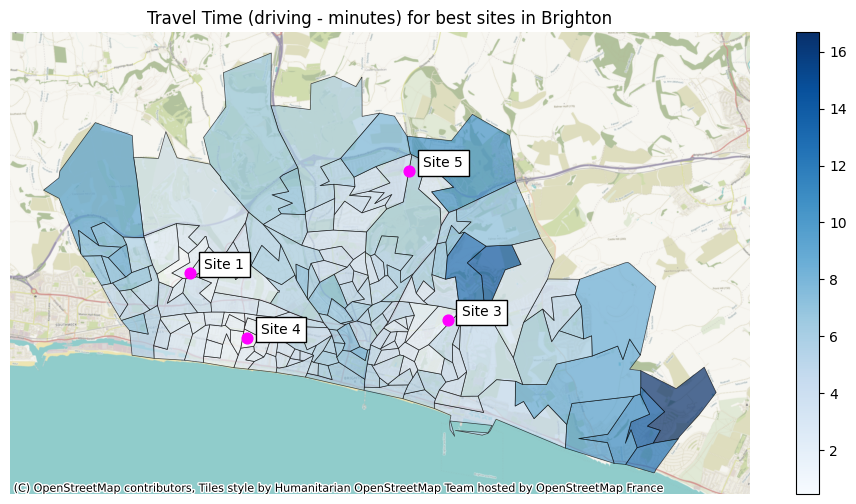

In [31]:
best_solution_df = pd.DataFrame(outputs).sort_values('weighted_average').head(1)['problem_df'].values[0]

nearest_site_travel_brighton_gdf = pd.merge(
    lsoa_boundaries,
    best_solution_df,
    right_on = "LSOA",
    left_on = "LSOA11NM"
)

nearest_site_travel_brighton_gdf["min_cost_minutes"] = nearest_site_travel_brighton_gdf["min_cost"] / 60

ax = nearest_site_travel_brighton_gdf.plot(
    "min_cost_minutes",
    legend=True,
    cmap="Blues",
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    figsize=(12,6)
    )

brighton_sites_bng = brighton_sites.to_crs('EPSG:27700').iloc[best_solution["site_indices"].values[0]]

hospital_points = brighton_sites_bng.plot(ax=ax, color='magenta', markersize=60)

cx.add_basemap(ax, crs=nearest_site_travel_brighton_gdf.crs.to_string(), zoom=14)

for x, y, label in zip(brighton_sites_bng.geometry.x,
                      brighton_sites_bng.geometry.y,
                      brighton_sites_bng.site):
    ax.annotate(label, xy=(x,y), xytext=(10,3), textcoords="offset points", bbox=dict(facecolor='white'))

ax.axis('off')

plt.title("Travel Time (driving - minutes) for best sites in Brighton")

In [32]:
len(pd.DataFrame(outputs))

15

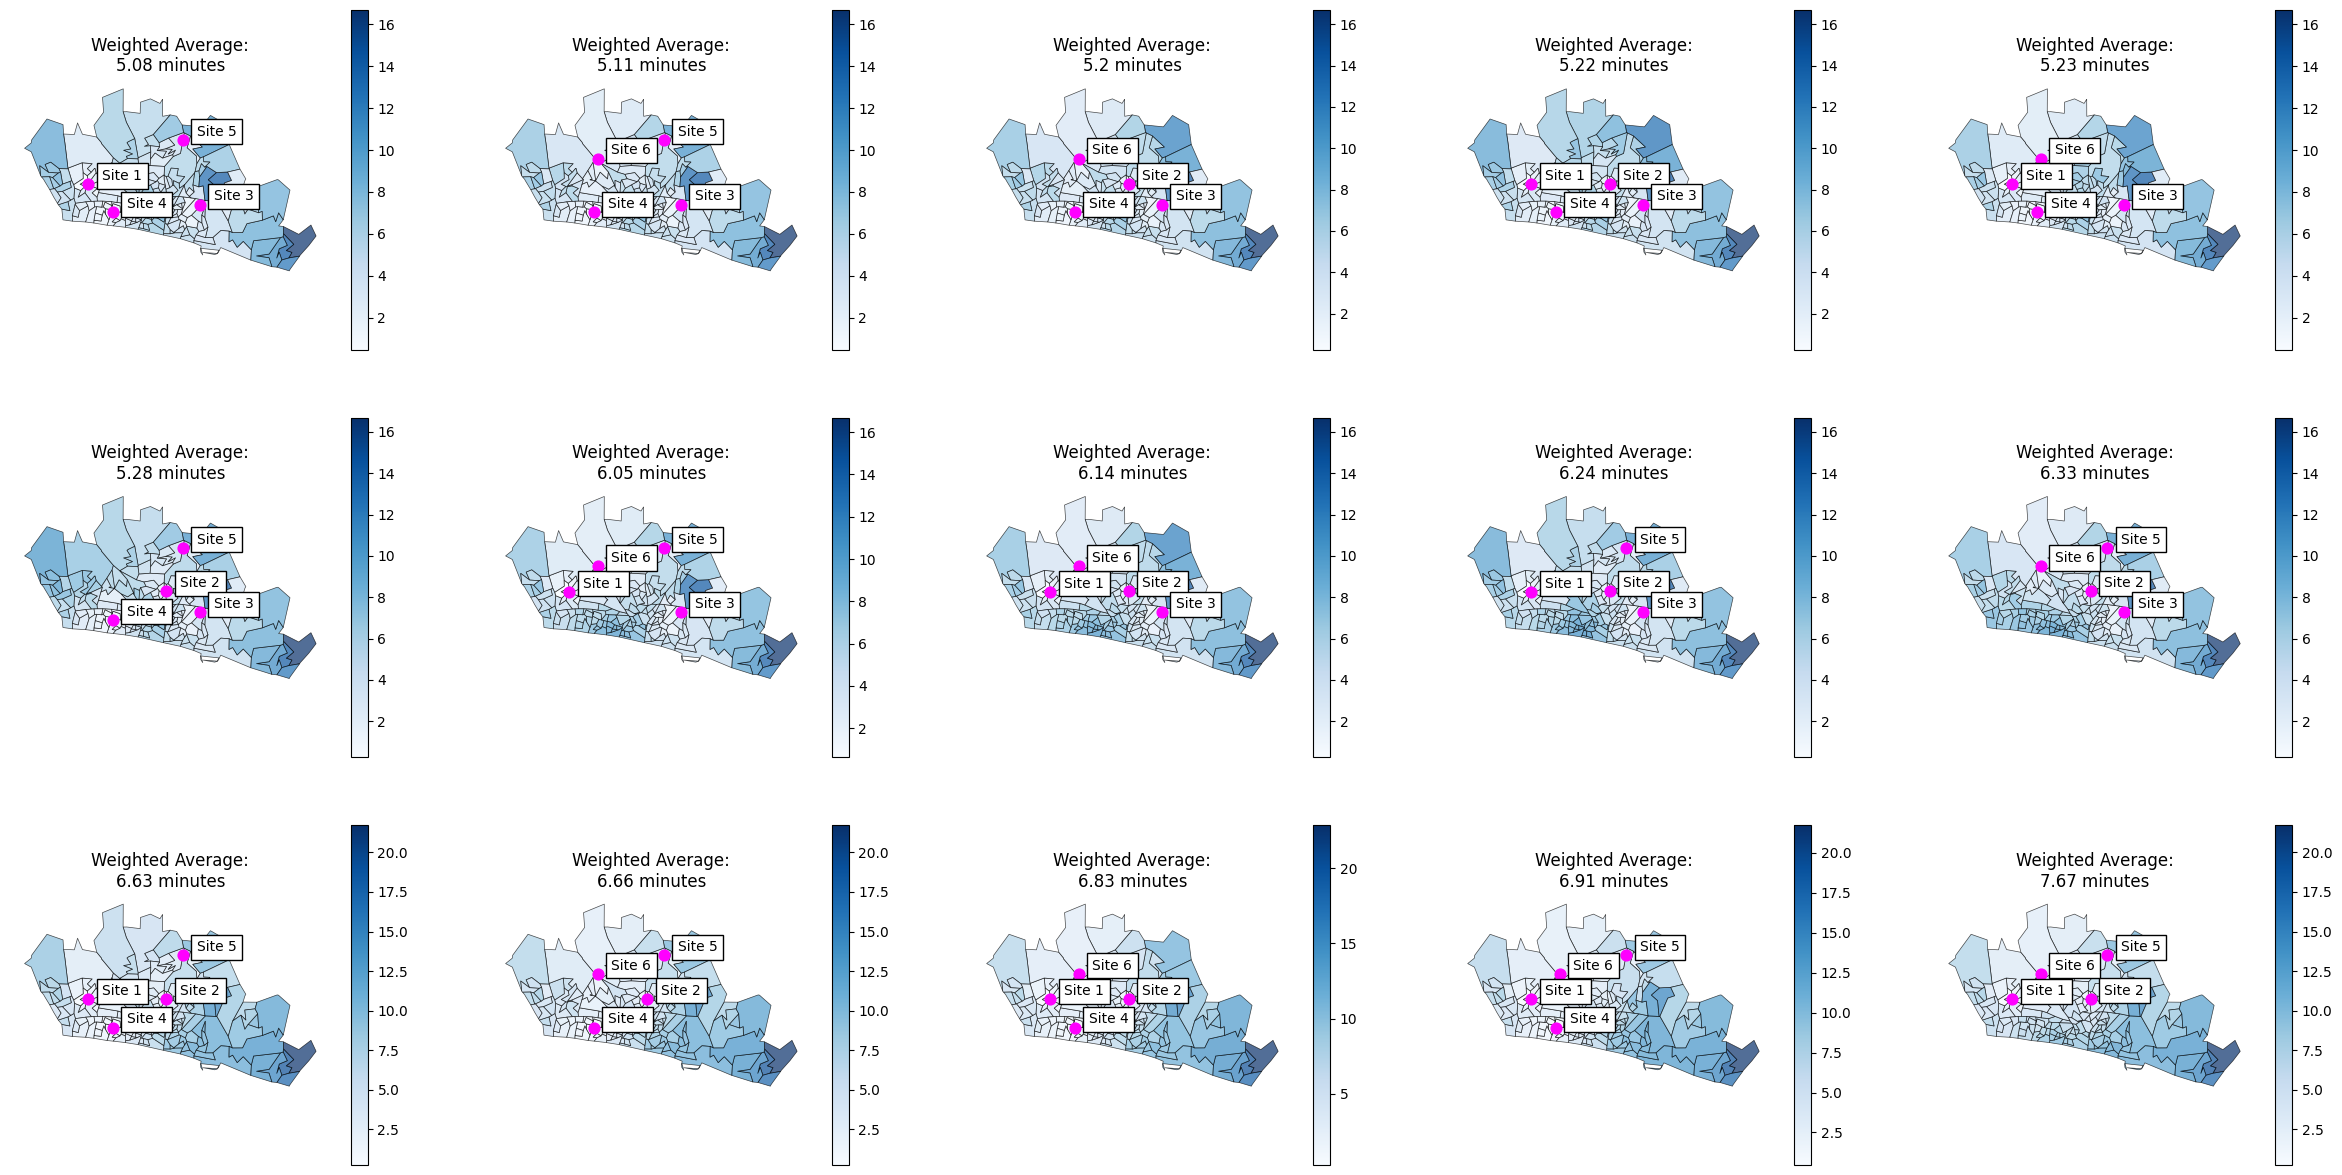

In [33]:
fig, axs = plt.subplots(3, 5, figsize=(30, 15))

for i, ax in enumerate(fig.axes):

    solution = pd.DataFrame(outputs).sort_values('weighted_average').iloc[[i]]
    solution_df = solution['problem_df'].values[0]

    nearest_site_travel_brighton_gdf = pd.merge(
        lsoa_boundaries,
        solution_df,
        right_on = "LSOA",
        left_on = "LSOA11NM"
    )

    nearest_site_travel_brighton_gdf["min_cost_minutes"] = nearest_site_travel_brighton_gdf["min_cost"] / 60

    ax = nearest_site_travel_brighton_gdf.plot(
        "min_cost_minutes",
        legend=True,
        cmap="Blues",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
        figsize=(12,6),
        ax=ax
        )

    brighton_sites_bng = brighton_sites.to_crs('EPSG:27700').iloc[solution["site_indices"].values[0]]

    hospital_points = brighton_sites_bng.plot(ax=ax, color='magenta', markersize=60)

    for x, y, label in zip(brighton_sites_bng.geometry.x,
                        brighton_sites_bng.geometry.y,
                        brighton_sites_bng.site):
        ax.annotate(label, xy=(x,y), xytext=(10,3), textcoords="offset points", bbox=dict(facecolor='white'))

    ax.axis('off')

    weighted_travel_time_solution = solution["weighted_average"].values[0]
    weighted_travel_time_solution_minutes = (weighted_travel_time_solution / 60).round(2)

    ax.set_title(f"Weighted Average:\n{weighted_travel_time_solution_minutes} minutes")

<img src="image-20240408-180455.png" width="" align="" />

In [34]:
def random_solution(n_candidates, p, random_seed=None):
    '''
    Helper function to generate a random solution

    Params
    ------
    n_candidates : int
        The number of candidate locations where you could place clinics (facilities).

    p : int
        The number of clinics to place.

    random_seed : int (Default=None)
        Random seed for reproducibility.

    Returns
    -------

    Vector (np.array) of length p
    '''
    # create a random number generator
    rng = np.random.default_rng(seed=random_seed)

    # create array of candidate indices
    candidates = np.arange(n_candidates, dtype=np.byte)

    # sample without replacement and return array
    return rng.choice(candidates, size=p, replace=False)

In [35]:
location_problem_brighton = FacilityLocationObjective(
    demand=brighton_demand,
    travel_matrix=brighton_travel,
    merge_col="LSOA",
    demand_col="demand"
    )

In [36]:

# NOTE RANDOM SEED NOT WORKING WHEN INCLUDED

def random_restarts(n_facilities, p, facility_location_object, max_iter=1000, #random_seed=None,
save_all_solution_outputs=False):
    '''
    max_iter : int
        Maximum number of iterations to try

    facility_location_object :  object
        WeightedAverageObjective

    n_facilities : int
        The number of candidate locations where you could place facilities (clinics).

    p : int
        The number of clinics to place.

    Returns
    -------

    best_cost : float
        Lowest 'cost'

    solution : array
        Indecies of clincs in solution.
    '''

    # np.random.seed(random_seed)

    # implementation of random restarts alg
    best_cost = np.Inf
    best_solution = None
    solution_progress = []

    all_outputs = []

    for i in range(max_iter):

        # We don't pass in a seed here, else we'd get the same solution every time!
        solution = random_solution(n_facilities, p)

        output = facility_location_object.generate_solution_metrics(
            solution
            )

        cost = output['weighted_average']

        if save_all_solution_outputs:
            all_outputs.append(output)

        if cost < best_cost:
            best_cost = cost
            best_solution = facility_location_object.travel_matrix.columns[solution]

        solution_progress.append({'iteration': i+1, 'best_cost': best_cost})

    if save_all_solution_outputs:
        return best_cost, solution, solution_progress, all_outputs
    else:
        return best_cost, solution, solution_progress


In [37]:
def random_restarts(n_facilities, p, facility_location_object, max_iter=1000):

    best_cost = np.Inf
    best_solution = None
    solution_progress = []

    for i in range(max_iter):

        # We don't pass in a seed here, else we'd get the same solution every time!
        solution = random_solution(n_facilities, p)

        output = facility_location_object.generate_solution_metrics(
            solution
            )

        cost = output['weighted_average']

        if cost < best_cost:
            best_cost = cost
            best_solution = facility_location_object.travel_matrix.columns[solution]

        solution_progress.append({'iteration': i+1, 'best_cost': best_cost})

    return best_cost, solution, solution_progress

In [38]:
def random_restarts(n_facilities, p, facility_location_object, max_iter=1000,
                    save_all_solution_outputs=False):

    best_cost = np.Inf
    best_solution = None
    solution_progress = []

    all_outputs = []

    for i in range(max_iter):

        # We don't pass in a seed here, else we'd get the same solution every time!
        solution = random_solution(n_facilities, p)

        output = facility_location_object.generate_solution_metrics(
            solution
            )

        cost = output['weighted_average']

        if save_all_solution_outputs:
            all_outputs.append(output)

        if cost < best_cost:
            best_cost = cost
            best_solution = facility_location_object.travel_matrix.columns[solution]

        solution_progress.append({'iteration': i+1, 'best_cost': best_cost})

    if save_all_solution_outputs:
        return best_cost, solution, solution_progress, all_outputs
    else:
        return best_cost, solution, solution_progress


In [39]:
# def random_restarts(n_facilities, p, facility_location_object, max_iter=1000):

#     best_cost = np.Inf
#     best_solution = None
#     solution_progress = []


#     for i in range(max_iter):

#         # We don't pass in a seed here, else we'd get the same solution every time!
#         solution = random_solution(n_facilities, p)

#         output = facility_location_object.generate_solution_metrics(
#             solution
#             )

#         cost = output['weighted_average']

#         if save_all_solution_outputs:
#             all_outputs.append(output)

#         if cost < best_cost:
#             best_cost = cost
#             best_solution = facility_location_object.travel_matrix.columns[solution]

#         solution_progress.append({'iteration': i+1, 'best_cost': best_cost})

#     return best_cost, solution, solution_progress


In [40]:
len(all_combinations(6,3))

20

In [41]:
location_problem_brighton = FacilityLocationObjective(
    demand=brighton_demand,
    travel_matrix=brighton_travel,
    merge_col="LSOA",
    demand_col="demand"
    )

now = datetime.now()
print(now.strftime("%H:%M:%S"))
best_cost, solution, solution_progress = random_restarts(
    n_facilities=6,
    p=3,
    max_iter=1000000,
    facility_location_object=location_problem_brighton,
    # random_seed=6
    )
print(datetime.now().strftime("%H:%M:%S"))
print((datetime.now() - now))

NameError: name 'datetime' is not defined

<AxesSubplot: xlabel='iteration'>

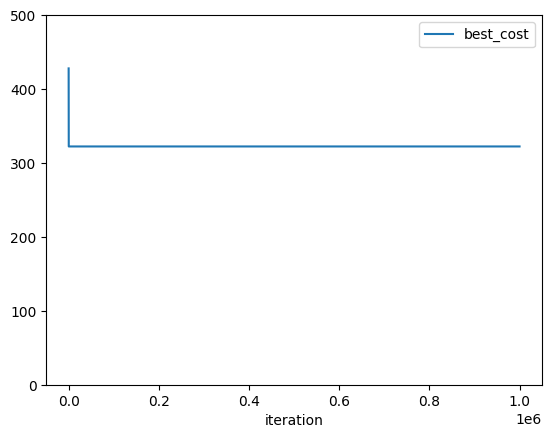

In [ ]:
pd.DataFrame(solution_progress).plot(x="iteration", y="best_cost", ylim=(0,500))

In [ ]:
best_cost/60

5.372207894707561

In [ ]:
solution

array([1, 3, 4], dtype=int8)

# Sexual health clinic example

In [ ]:
sexual_health_clinics_tt = pd.read_excel("pone.0183942.s004.xlsx", sheet_name="Travel Time Driving")

In [ ]:
sexual_health_clinics_tt["Clinic 1"][0]

datetime.time(0, 33, 10, 138000)

In [ ]:
# slightly toundabout conversion of time objects to minutes

sexual_health_clinics_tt = sexual_health_clinics_tt.set_index("Locations").astype(str).astype('timedelta64[s]').astype(int).applymap(lambda x: x/60).reset_index()

/tmp/ipykernel_139/3859721726.py:3: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
sexual_health_clinics_demand = pd.read_excel("pone.0183942.s004.xlsx", sheet_name="Patients")

In [ ]:
from math import factorial

In [ ]:
num_options = len(sexual_health_clinics_tt.set_index('Locations').columns)
num_clinics = 20

f"{factorial(num_options) / (factorial(num_options-num_clinics) * factorial(num_clinics)):.0f}"

'11290838603408335008742942703616'

In [ ]:
num_options

306

In [ ]:
sexual_health_clinics_demand

,Location,No. Patients (Over the whole period)
0,Postcode sector 1,3375
1,Postcode sector 2,3338
2,Postcode sector 3,2922
3,Postcode sector 4,3191
4,Postcode sector 5,3134
...,...,...
273,Postcode sector 274,216
274,Postcode sector 275,261
275,Postcode sector 276,342
276,Postcode sector 277,0


In [ ]:
sexual_health_clinics_tt = sexual_health_clinics_tt[~sexual_health_clinics_tt["Locations"].isna()]

sexual_health_clinics_tt

,Locations,Clinic 1,Clinic 10,Clinic 11,Clinic 12,Clinic 13,Clinic 14,Clinic 15,Clinic 16,Clinic 17,...,Postcode sector 154,Postcode sector 91,Postcode sector 30,Postcode sector 155,Postcode sector 156,Postcode sector 273,Postcode sector 157,Postcode sector 274,Postcode sector 275,Postcode sector 276
0,Postcode sector 158,33.166667,40.133333,38.150000,37.916667,29.350000,51.466667,53.283333,48.000000,53.800000,...,51.333333,52.333333,53.400000,55.983333,52.866667,56.466667,51.433333,51.750000,49.433333,59.783333
1,Postcode sector 159,31.416667,36.533333,36.400000,34.516667,27.600000,47.866667,49.683333,44.400000,50.200000,...,47.733333,48.733333,49.800000,52.383333,49.266667,52.866667,47.833333,48.150000,45.850000,56.183333
2,Postcode sector 160,31.816667,38.783333,36.800000,36.566667,28.000000,50.116667,51.933333,46.650000,52.450000,...,49.983333,50.983333,52.050000,54.633333,51.516667,55.116667,50.083333,50.400000,48.100000,58.433333
3,Postcode sector 161,31.666667,38.650000,36.666667,36.416667,27.850000,49.983333,51.783333,46.500000,52.316667,...,49.833333,50.833333,51.916667,54.483333,51.366667,54.966667,49.933333,50.250000,47.950000,58.300000
4,Postcode sector 162,29.550000,36.516667,34.533333,34.300000,25.733333,47.850000,49.666667,44.383333,50.183333,...,47.716667,48.716667,49.783333,52.366667,49.250000,52.850000,47.816667,48.133333,45.816667,56.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Postcode sector 273,34.116667,21.833333,39.216667,35.900000,34.683333,49.250000,49.083333,45.766667,51.583333,...,2.250000,5.550000,4.233333,5.616667,0.000000,6.100000,5.716667,7.950000,13.133333,13.133333
274,Postcode sector 157,29.583333,17.283333,34.683333,31.366667,30.150000,44.716667,44.550000,41.233333,47.050000,...,6.616667,7.300000,5.116667,1.150000,6.066667,0.000000,10.083333,8.966667,12.583333,10.416667
275,Postcode sector 274,31.166667,18.366667,36.266667,32.933333,31.733333,46.300000,46.133333,42.816667,48.633333,...,3.550000,6.433333,6.816667,8.200000,5.083333,8.683333,0.000000,7.750000,14.616667,15.166667
276,Postcode sector 275,34.400000,23.716667,39.400000,37.500000,30.583333,50.850000,52.666667,47.383333,53.200000,...,6.950000,5.150000,7.633333,10.250000,8.466667,10.233333,9.350000,0.000000,10.366667,14.300000


In [ ]:
location_problem_sh = FacilityLocationObjective(
    demand=sexual_health_clinics_demand,
    travel_matrix=sexual_health_clinics_tt.rename(columns={"Locations":"Location"}),
    merge_col="Location",
    demand_col="No. Patients (Over the whole period)"
    )

best_cost, solution, solution_progress = random_restarts(
    n_facilities=len(sexual_health_clinics_tt.set_index('Locations').columns),
    p=20,
    max_iter=1000,
    facility_location_object=location_problem_sh,
    # random_seed=42
    )


In [ ]:
best_cost.round(5)

5.85873

<AxesSubplot: xlabel='iteration'>

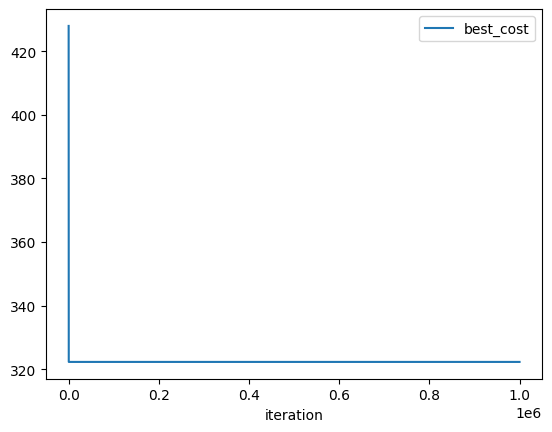

In [ ]:
pd.DataFrame(solution_progress).plot(x="iteration", y="best_cost")

In [ ]:
location_problem_sh = FacilityLocationObjective(
    demand=sexual_health_clinics_demand,
    travel_matrix=sexual_health_clinics_tt.rename(columns={"Locations":"Location"}),
    merge_col="Location",
    demand_col="No. Patients (Over the whole period)"
    )

best_cost, solution, solution_progress = random_restarts(
    n_facilities=len(sexual_health_clinics_tt.set_index('Locations').columns),
    p=20,
    max_iter=1000,
    facility_location_object=location_problem_sh,
    # random_seed=99
    )


In [ ]:
best_cost.round(5)

6.01016

<AxesSubplot: xlabel='iteration'>

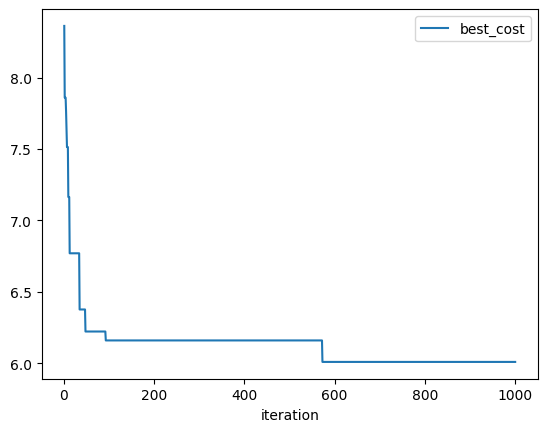

In [ ]:
pd.DataFrame(solution_progress).plot(x="iteration", y="best_cost")

In [ ]:
location_problem_sh = FacilityLocationObjective(
    demand=sexual_health_clinics_demand,
    travel_matrix=sexual_health_clinics_tt.rename(columns={"Locations":"Location"}),
    merge_col="Location",
    demand_col="No. Patients (Over the whole period)"
    )

best_cost, solution, solution_progress = random_restarts(
    n_facilities=len(sexual_health_clinics_tt.set_index('Locations').columns),
    p=20,
    max_iter=10000,
    facility_location_object=location_problem_sh,
    # random_seed=99
    )


In [ ]:
best_cost.round(5)

5.56493

<AxesSubplot: xlabel='iteration'>

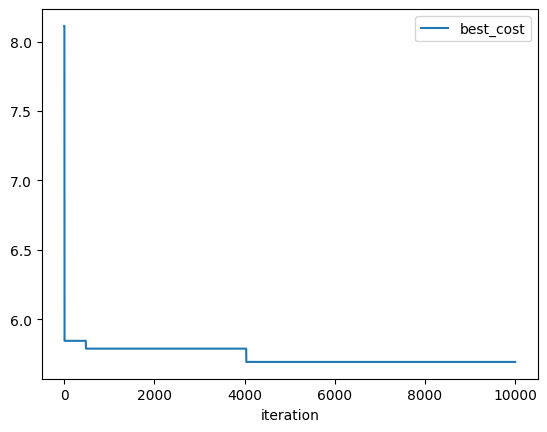

In [ ]:
pd.DataFrame(solution_progress).plot(x="iteration", y="best_cost")

In [ ]:
location_problem_sh = FacilityLocationObjective(
    demand=sexual_health_clinics_demand,
    travel_matrix=sexual_health_clinics_tt.rename(columns={"Locations":"Location"}),
    merge_col="Location",
    demand_col="No. Patients (Over the whole period)"
    )

best_cost, solution, solution_progress = random_restarts(
    n_facilities=len(sexual_health_clinics_tt.set_index('Locations').columns),
    p=20,
    max_iter=100000,
    facility_location_object=location_problem_sh,
    # random_seed=99
    )


In [ ]:
best_cost.round(5)

5.47982

<AxesSubplot: xlabel='iteration'>

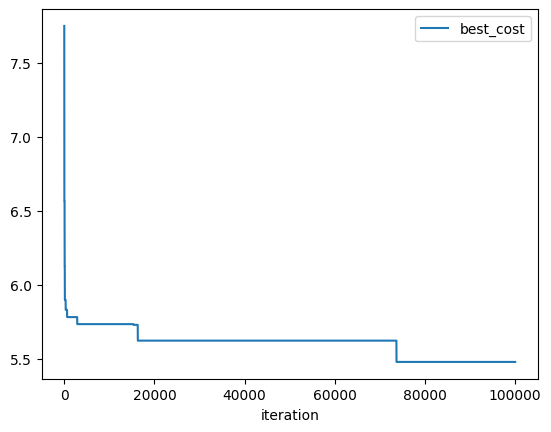

In [ ]:
pd.DataFrame(solution_progress).plot(x="iteration", y="best_cost")

13:22:33
14:00:33
0:37:59.397320


<AxesSubplot: xlabel='iteration'>

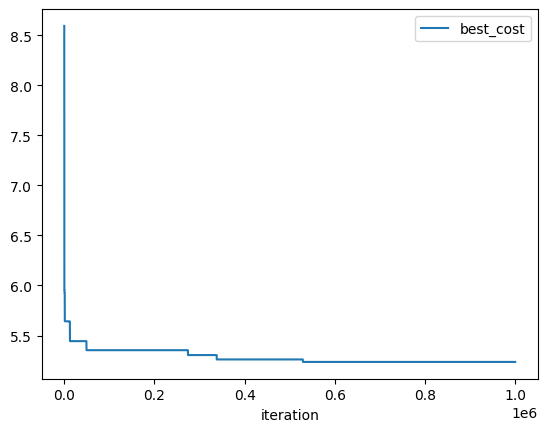

In [ ]:

location_problem_sh = FacilityLocationObjective(
    demand=sexual_health_clinics_demand,
    travel_matrix=sexual_health_clinics_tt.rename(columns={"Locations":"Location"}),
    merge_col="Location",
    demand_col="No. Patients (Over the whole period)"
    )

now = datetime.now()
print(now.strftime("%H:%M:%S"))

best_cost, solution, solution_progress = random_restarts(
    n_facilities=len(sexual_health_clinics_tt.set_index('Locations').columns),
    p=20,
    max_iter=1000000,
    facility_location_object=location_problem_sh,
    # random_seed=99
    )


print(datetime.now().strftime("%H:%M:%S"))
print((datetime.now() - now))

pd.DataFrame(solution_progress).plot(x="iteration", y="best_cost")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c661ea7-9b58-4649-92ed-c2a834b4f69c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>